# Clustering Analysis - Customer Segmentation

This notebook performs comprehensive clustering analysis using multiple algorithms:
- K-Means
- Hierarchical Clustering
- DBSCAN
- Gaussian Mixture Models (GMM)

## Workflow:
1. Data Loading
2. Exploratory Data Analysis (EDA)
3. Data Preprocessing (One-Hot Encoding + Scaling)
4. Model Training & Evaluation
5. Model Comparison
6. Cluster Interpretation

## 1. Import Libraries

In [1]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture

# Import custom utilities
from utils.entrega1.data_loader import load_data
from utils.entrega1.eda import check_missing_values_viz, plot_distributions_numerical
from utils.entrega1.preprocessing import preprocess_pipeline
from utils.entrega1.modeling import (
    evaluate_clusters_kmeans,
    plot_knn_distance,
    optimize_dbscan_grid,
    evaluate_gmm_bic,
    compare_all_models_silhouette,
    visualize_clusters_pca,
    interpret_clusters
)

# Display settings
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('viridis')

## 2. Load Data

In [2]:
# Load dataset
df = load_data('../data/datos_caso_1.csv')
print(f"Dataset shape: {df.shape}")
df.head()

Data loaded successfully with shape: (2240, 29)
Dataset shape: (2240, 29)


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0


In [3]:
# Dataset info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

## 3. Exploratory Data Analysis (EDA)

<Figure size 1000x600 with 0 Axes>

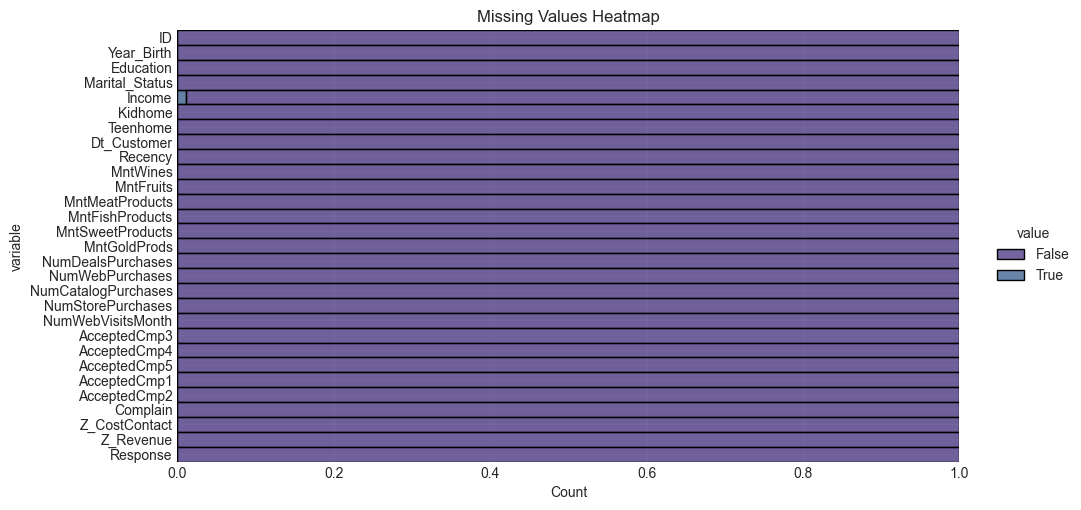

In [4]:
# Check missing values
check_missing_values_viz(df)

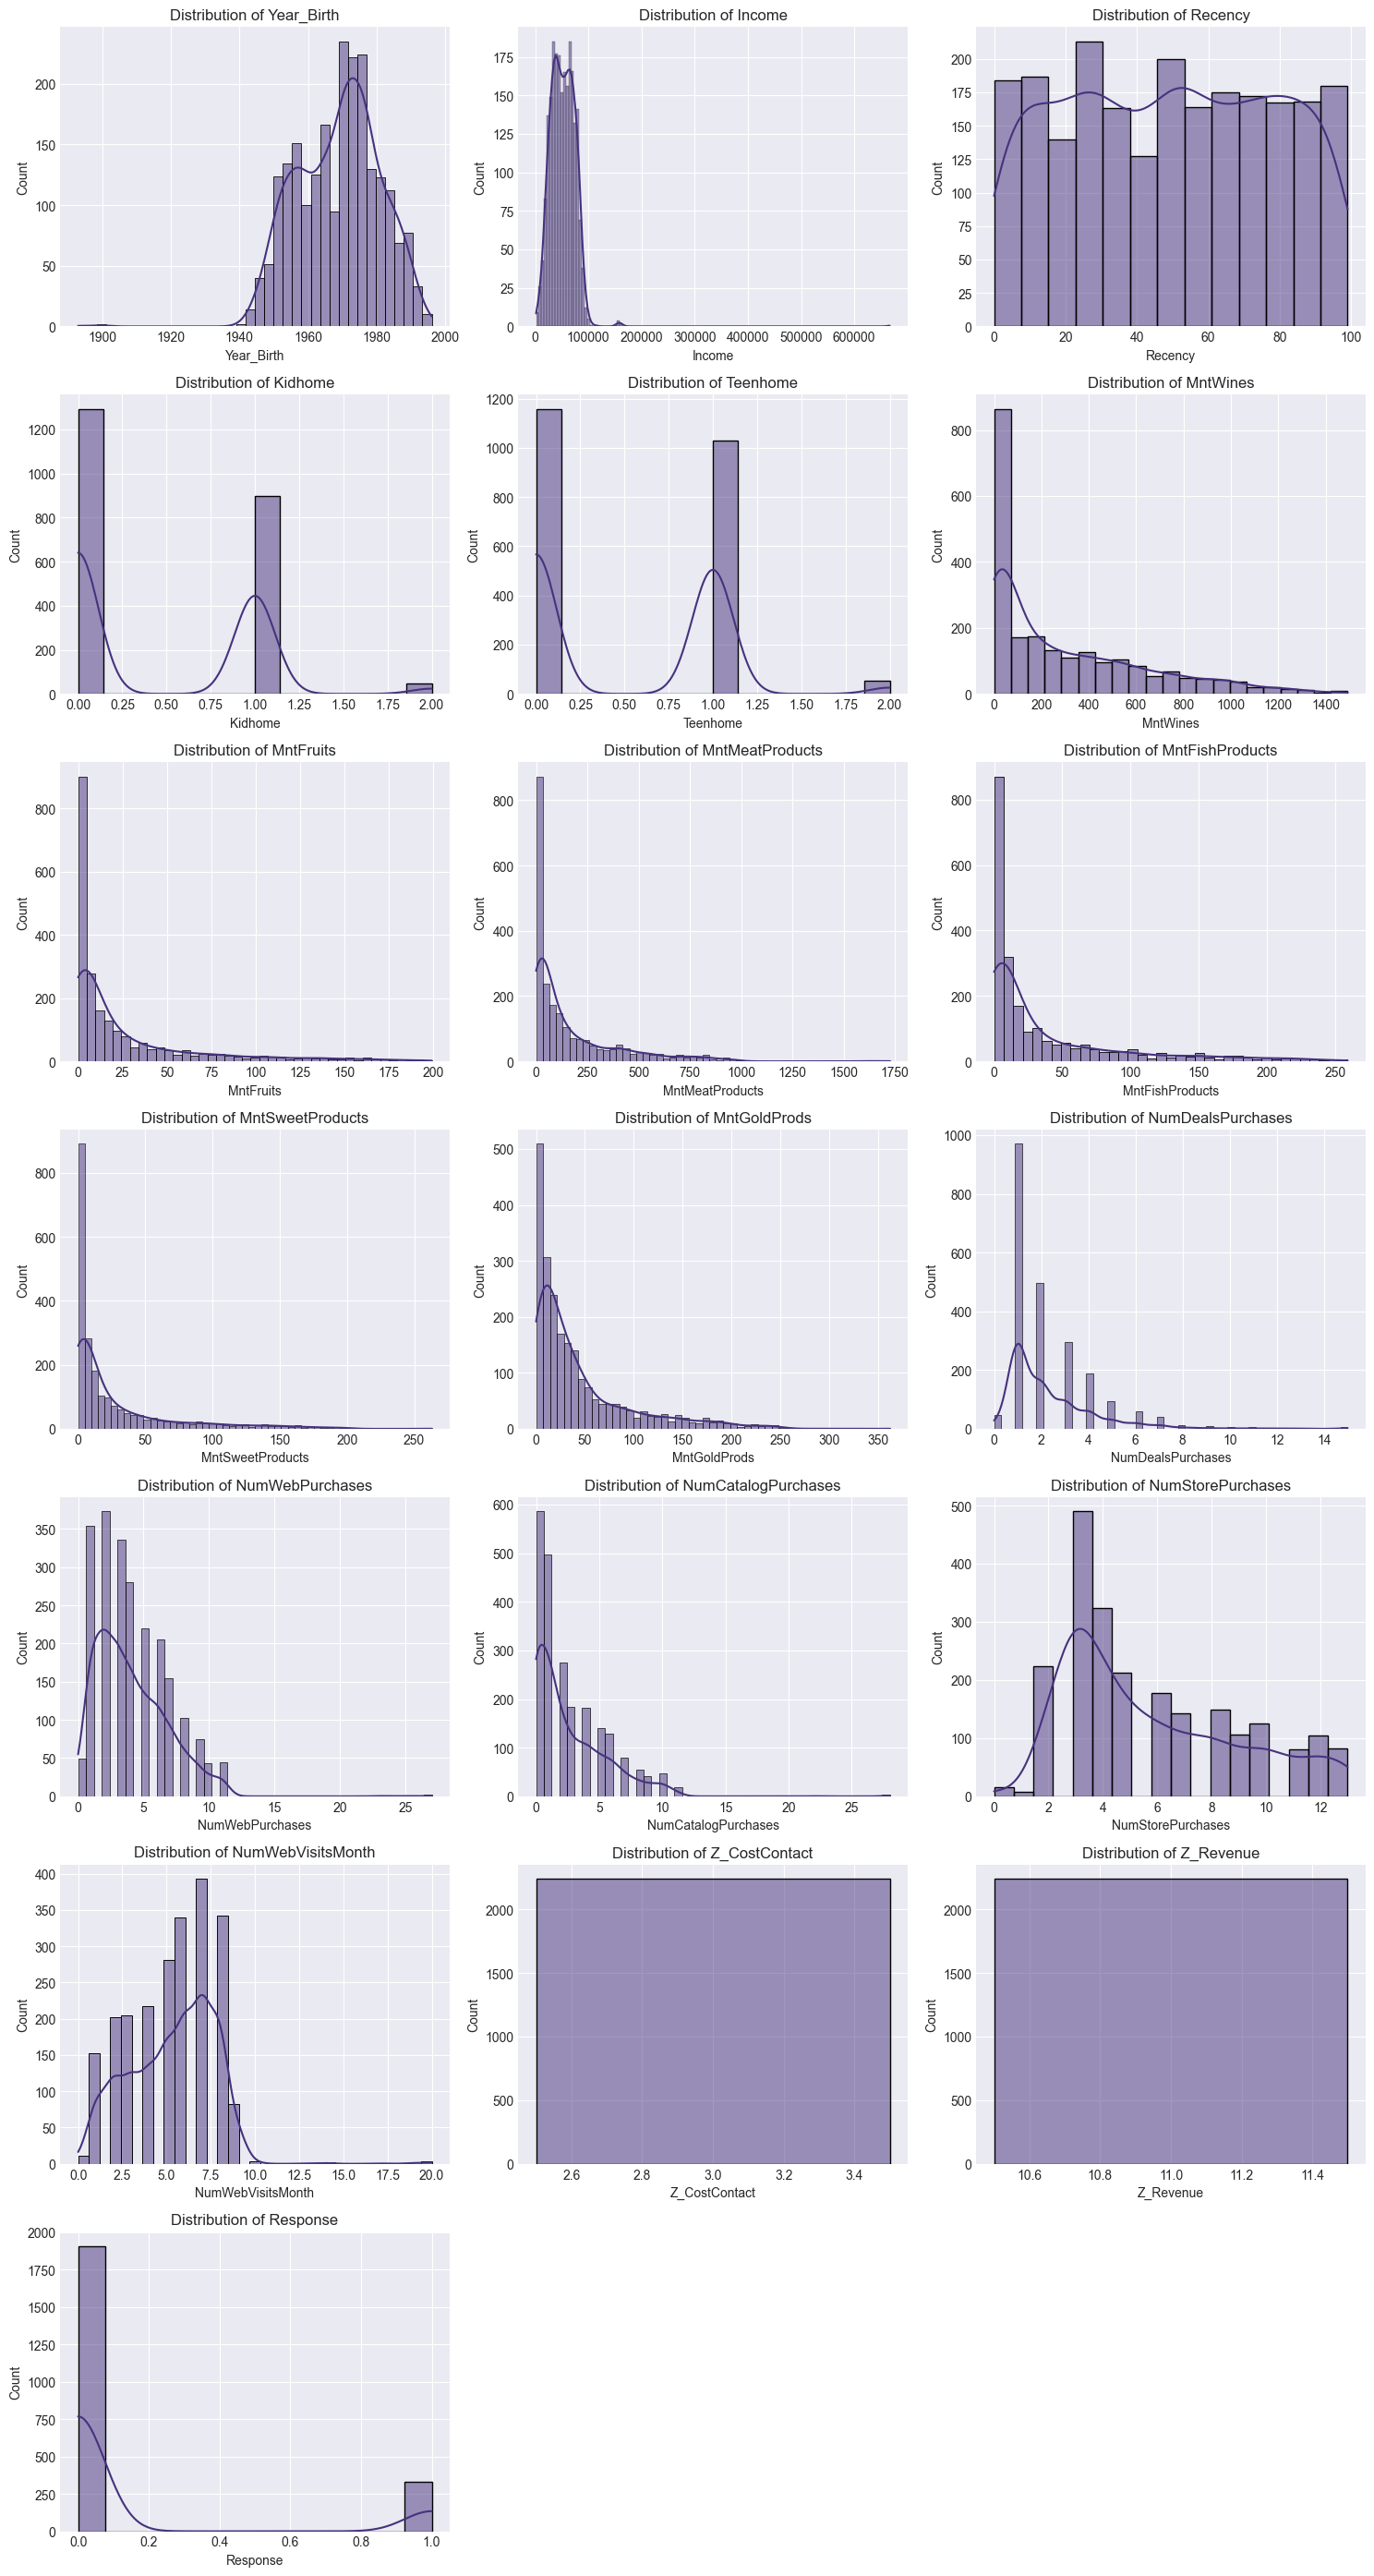

In [5]:
# Numerical distributions
eda_numerical_cols = ['Year_Birth', 'Income', 'Recency', 'Kidhome', 'Teenhome', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'Z_CostContact', 'Z_Revenue', 'Response']
plot_distributions_numerical(df, eda_numerical_cols)

## 4. Data Preprocessing

The preprocessing pipeline:
1. Handles missing values
2. Removes atypical values
3. Creates engineered features (Age, Tenure, Total Purchases, etc.)
4. **One-Hot Encodes** categorical features (Education, Marital_Status)
5. **Scales** numerical features using StandardScaler

**Important:** The pipeline returns transformers and feature lists for inverse transformation.

In [6]:
# Preprocess data - returns scaled data, transformers, and feature lists
df_scaled, scaler, encoder, all_feature_cols, num_feature_cols, ohe_feature_cols, categorical_cols = preprocess_pipeline(df)

print(f"Scaled data shape: {df_scaled.shape}")
print(f"Total features: {len(all_feature_cols)}")
print(f"Numerical features: {len(num_feature_cols)}")
print(f"OHE features: {len(ohe_feature_cols)}")
df_scaled.head()

Scaled data shape: (2204, 40)
Total features: 40
Numerical features: 30
OHE features: 10


,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Z_CostContact,Z_Revenue,Age,Tenure_Days,Total_Mnt,Total_Num_Purchases,Is_Partner,Family_Size,Days_Being_Customer,Total_Offers_Accepted,Education_2n Cycle,Education_Basic,Education_Graduation,Education_Master,Education_PhD,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow
0,0.298477,-0.824489,-0.930318,0.308869,0.975235,1.551376,1.773827,2.461916,1.480571,0.856812,0.371535,1.426001,2.688335,-0.559167,0.690579,-0.2826,-0.283535,-0.279782,-0.261433,-0.117471,0.0,0.0,1.016221,1.530603,1.682887,1.334369,-1.351163,-1.760860,1.530603,0.617741,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,-0.258794,1.037369,0.906977,-0.382701,-0.873024,-0.637456,-0.735570,-0.651784,-0.634918,-0.734870,-0.164020,-1.129207,-0.592850,-1.175062,-0.137064,-0.2826,-0.283535,-0.279782,-0.261433,-0.117471,0.0,0.0,1.272661,-1.187609,-0.960984,-1.161412,-1.351163,0.446726,-1.187609,-0.502836,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.935177,-0.824489,-0.930318,-0.797644,0.356187,0.570175,-0.173279,1.344647,-0.148599,-0.036083,-0.699575,1.426001,-0.228274,1.288516,-0.550886,-0.2826,-0.283535,-0.279782,-0.261433,-0.117471,0.0,0.0,0.332380,-0.204110,0.284462,0.808942,0.740103,-0.657067,-0.204110,-0.502836,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,-1.189533,1.037369,-0.930318,-0.797644,-0.873024,-0.561979,-0.670511,-0.505257,-0.586286,-0.754280,-0.164020,-0.764178,-0.957426,-0.559167,0.276757,-0.2826,-0.283535,-0.279782,-0.261433,-0.117471,0.0,0.0,-1.291743,-1.059111,-0.917751,-0.898698,0.740103,0.446726,-1.059111,-0.502836,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.305801,1.037369,-0.930318,1.553696,-0.393187,0.419221,-0.215102,0.154114,-0.002703,-0.560173,1.442646,0.330912,0.136302,0.056727,-0.137064,-0.2826,-0.283535,-0.279782,-0.261433,-0.117471,0.0,0.0,-1.035303,-0.950383,-0.304173,0.546228,0.740103,0.446726,-0.950383,-0.502836,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


## 5. K-Means Clustering

### 5.1 Determine Optimal K (Elbow + Silhouette)

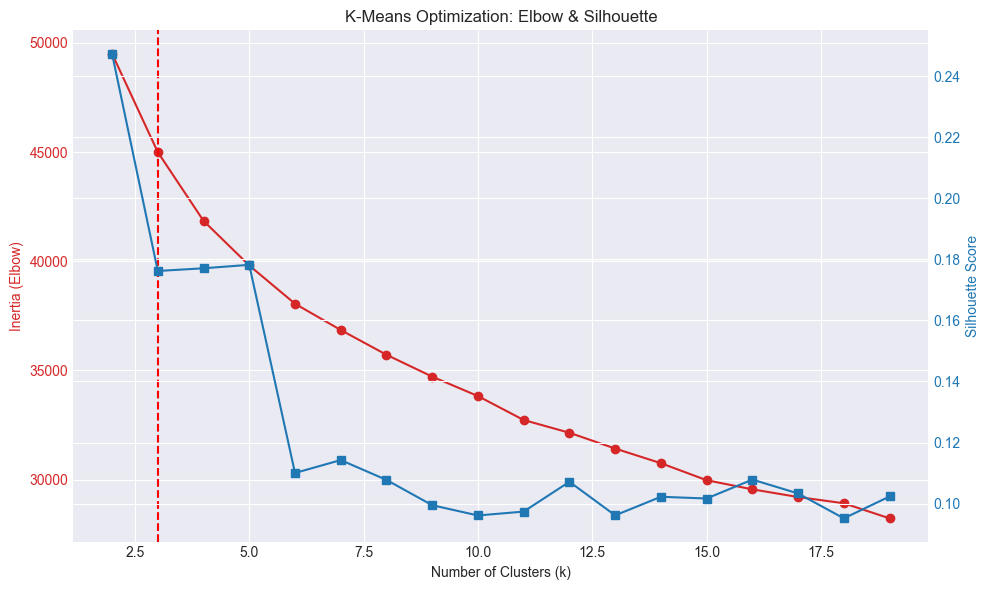

In [7]:
# Evaluate K-Means for k=2 to k=19 with reference line at k=3
evaluate_clusters_kmeans(df_scaled, range(2, 20), include_silhouette=True, ref_cluster=3, n_init=20)

### 5.2 Fit Final K-Means Model

In [ ]:
# Based on elbow/silhouette analysis, choose optimal k (e.g., 6)
optimal_k = 5

kmeans_final = KMeans(n_clusters=optimal_k, n_init=20, random_state=123)
kmeans_final.fit(df_scaled)

print(f"K-Means with k={optimal_k} fitted successfully")
print(f"Inertia: {kmeans_final.inertia_:.2f}")

K-Means with k=6 fitted successfully
Inertia: 38056.11


In [9]:
# Display cluster centers (scaled values)
print("Cluster Centers (Scaled):")
centers_scaled = pd.DataFrame(kmeans_final.cluster_centers_, columns=all_feature_cols)
centers_scaled

Cluster Centers (Scaled):


,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Z_CostContact,Z_Revenue,Age,Tenure_Days,Total_Mnt,Total_Num_Purchases,Is_Partner,Family_Size,Days_Being_Customer,Total_Offers_Accepted,Education_2n Cycle,Education_Basic,Education_Graduation,Education_Master,Education_PhD,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow
0,-1.053572,0.652481,-0.846945,-0.042147,-0.807602,-0.502570,-0.645527,-0.503534,-0.501528,-0.509574,-0.242328,-0.695466,-0.761351,-0.827780,0.651631,0.038507,-0.264323,-0.279782,-0.254565,-0.117471,0.0,0.0,-0.711340,0.012466,-0.841242,-0.937112,-0.068285,-0.158042,0.012466,-0.263654,0.121008,8.403361e-02,0.509244,0.151261,0.134454,0.090756,0.383193,0.277311,0.230252,0.018487
1,0.299200,-0.421025,0.793744,-0.023236,0.562988,-0.035141,-0.065483,-0.079732,-0.043020,0.444671,0.879408,0.985498,0.266042,0.676907,0.238090,0.036464,0.163415,-0.264458,-0.139569,-0.117471,0.0,0.0,0.334419,0.402464,0.318214,0.954923,0.054101,0.255811,0.402464,-0.092923,0.057654,3.976143e-03,0.489066,0.180915,0.268390,0.125249,0.409543,0.163022,0.262425,0.039761
2,-0.360029,0.519984,0.899786,0.057617,-0.671188,-0.548489,-0.634435,-0.580134,-0.545030,-0.564807,0.078080,-0.606308,-0.674184,-0.636908,0.163381,-0.103132,-0.179140,-0.279782,-0.237441,-0.117471,0.0,0.0,0.430740,-0.394100,-0.778387,-0.713616,0.130321,0.917620,-0.394100,-0.364683,0.082192,3.913894e-03,0.454012,0.191781,0.268102,0.107632,0.409002,0.152642,0.299413,0.031311
3,0.995505,-0.755701,-0.586391,0.033093,0.560737,1.163209,1.186722,1.230285,1.077141,0.618576,-0.542602,0.332710,1.074682,0.832663,-1.056441,-0.141424,-0.161526,-0.279782,0.100918,-0.117471,0.0,0.0,0.101415,-0.027311,1.054647,0.729028,-0.151003,-0.880001,-0.027311,-0.157831,0.098522,2.081668e-17,0.578818,0.133005,0.189655,0.105911,0.330049,0.268473,0.243842,0.051724
4,1.439708,-0.719101,-0.710767,-0.035829,1.635043,0.800404,1.556118,0.855532,0.998075,0.653305,-0.679366,0.528349,1.255253,0.740409,-1.006349,0.318213,0.986610,3.137912,1.614763,-0.117471,0.0,0.0,-0.051475,0.006384,1.729498,0.791593,0.056167,-0.823678,0.006384,2.182320,0.081761,-3.469447e-18,0.503145,0.182390,0.232704,0.069182,0.440252,0.213836,0.232704,0.044025
5,0.908803,-0.700365,-0.134157,-0.013864,1.756203,-0.084797,0.399700,0.021019,0.084834,0.437540,-0.324687,0.294409,0.926217,0.723946,-0.068094,0.609006,2.510784,1.904149,1.509388,8.512736,0.0,0.0,0.064542,0.053378,1.168524,0.668828,-0.026694,-0.509895,0.053378,3.568594,0.066667,0.000000e+00,0.533333,0.066667,0.333333,0.166667,0.233333,0.166667,0.400000,0.033333


### 5.3 Visualize K-Means Clusters (PCA)

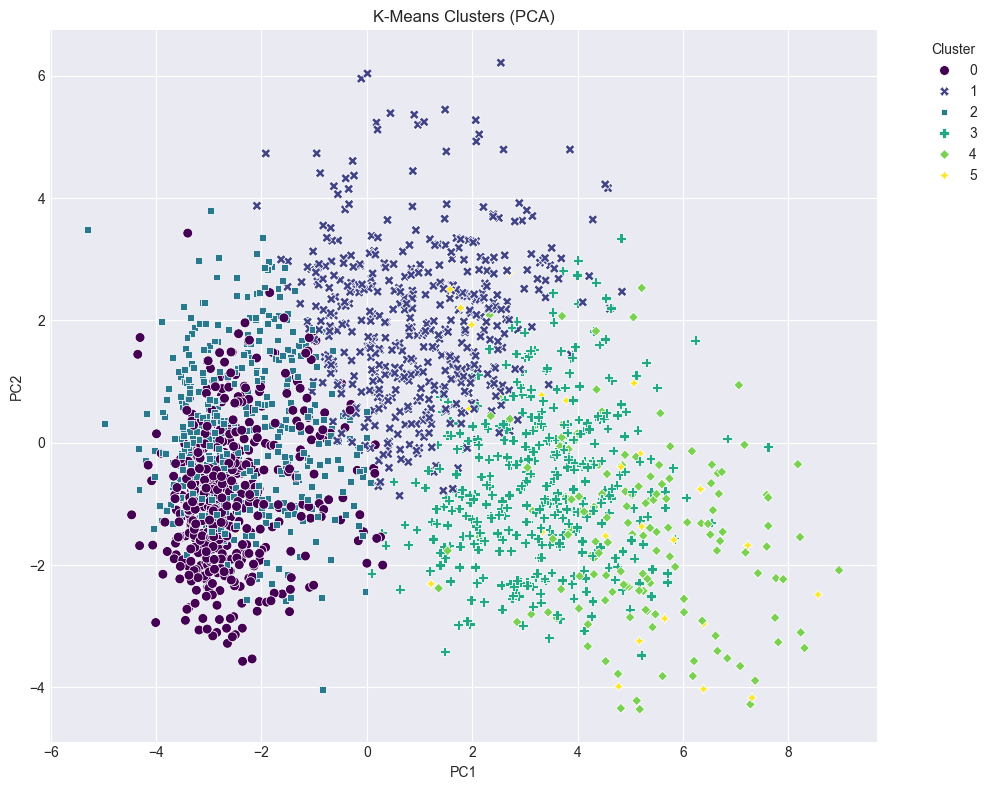

In [10]:
labels_kmeans = kmeans_final.labels_
visualize_clusters_pca(df_scaled, labels_kmeans, title='K-Means Clusters (PCA)')

## 6. Hierarchical Clustering

In [11]:
# Fit hierarchical clustering with same number of clusters as K-Means
h_cluster_final = AgglomerativeClustering(n_clusters=optimal_k)
labels_h_clust = h_cluster_final.fit_predict(df_scaled)

print(f"Hierarchical Clustering with {optimal_k} clusters fitted")
print(f"Cluster distribution: {np.bincount(labels_h_clust)}")

Hierarchical Clustering with 6 clusters fitted
Cluster distribution: [513 223 890 427  30 121]


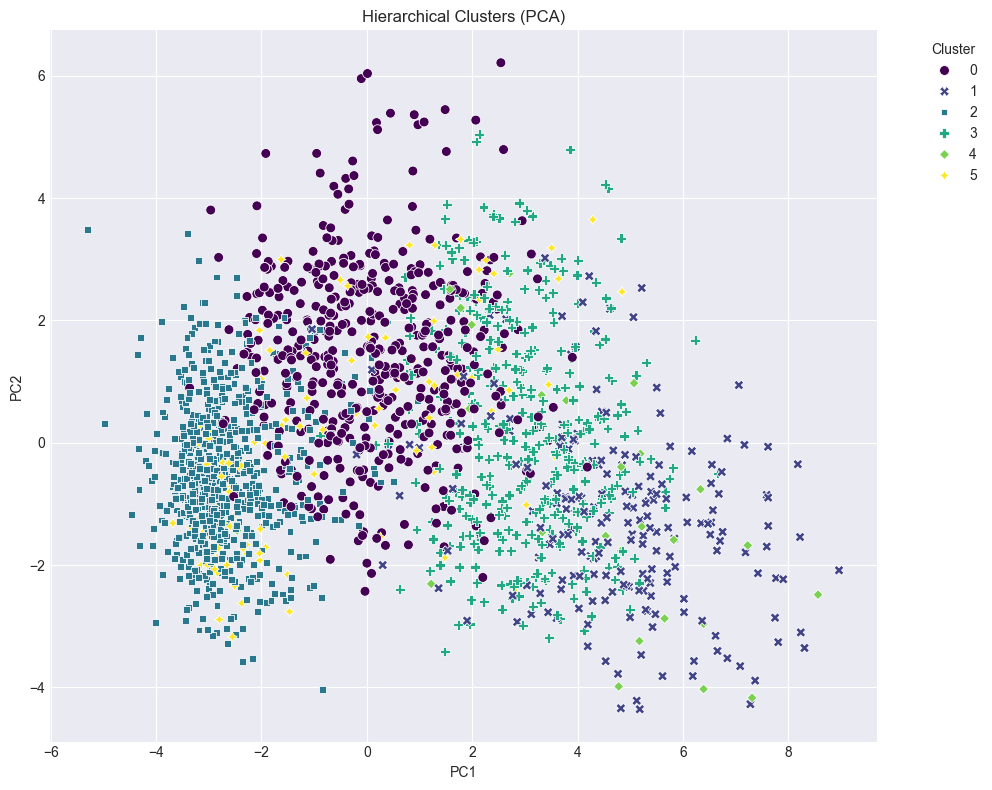

In [12]:
# Visualize hierarchical clusters
visualize_clusters_pca(df_scaled, labels_h_clust, title='Hierarchical Clusters (PCA)')

## 7. DBSCAN Clustering

### 7.1 K-NN Distance Plot (Estimate Epsilon)

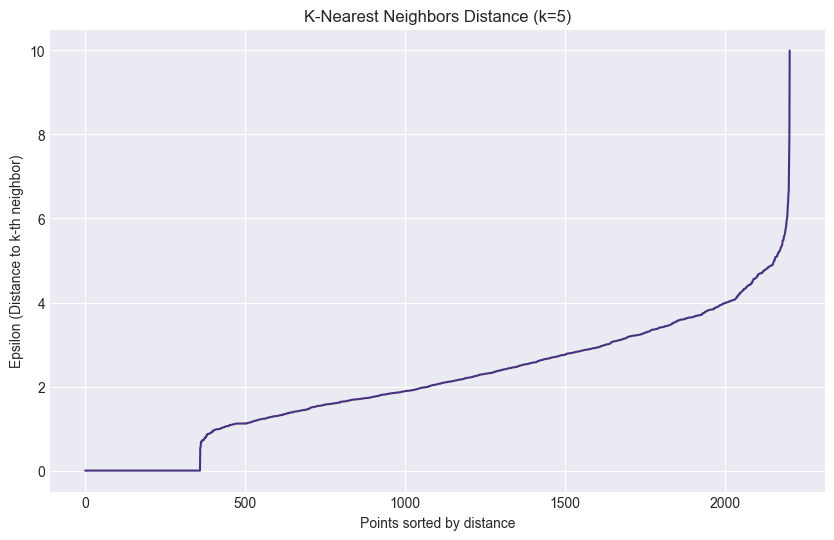

In [13]:
# Plot k-nearest neighbors distance
plot_knn_distance(df_scaled, k=5)

### 7.2 Grid Search for Optimal Hyperparameters

Optimizing DBSCAN hyperparameters...


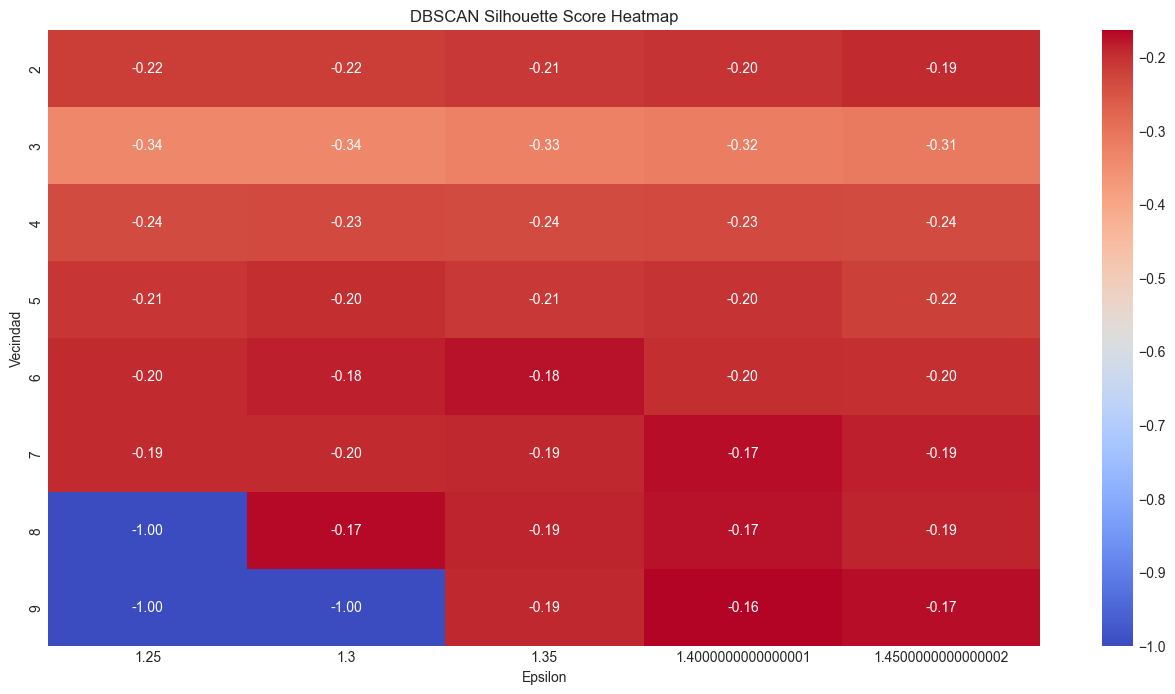

In [14]:
# Grid search for epsilon and min_samples
eps_values = np.arange(1.25, 1.50, 0.05)
min_samples_values = np.arange(2, 10)

print("Optimizing DBSCAN hyperparameters...")
dbscan_results = optimize_dbscan_grid(df_scaled, eps_values, min_samples_values)

In [15]:
# View best parameters
best_idx = dbscan_results['Score'].idxmax()
best_params = dbscan_results.loc[best_idx]
print(f"Best DBSCAN parameters:")
print(f"  Epsilon: {best_params['Epsilon']:.2f}")
print(f"  Vecindad (min_samples): {int(best_params['Vecindad'])}")
print(f"  Silhouette Score: {best_params['Score']:.4f}")

Best DBSCAN parameters:
  Epsilon: 1.40
  Vecindad (min_samples): 9
  Silhouette Score: -0.1632


### 7.3 Fit Final DBSCAN Model

In [16]:
# Fit DBSCAN with optimal parameters
dbscan_final = DBSCAN(eps=best_params['Epsilon'], min_samples=int(best_params['Vecindad']))
labels_dbscan = dbscan_final.fit_predict(df_scaled)

print(f"DBSCAN fitted")
print(f"Unique clusters: {np.unique(labels_dbscan)}")
print(f"Cluster distribution: {np.bincount(labels_dbscan[labels_dbscan >= 0])}")
print(f"Noise points: {np.sum(labels_dbscan == -1)}")

DBSCAN fitted
Unique clusters: [-1  0  1]
Cluster distribution: [18 22]
Noise points: 2164


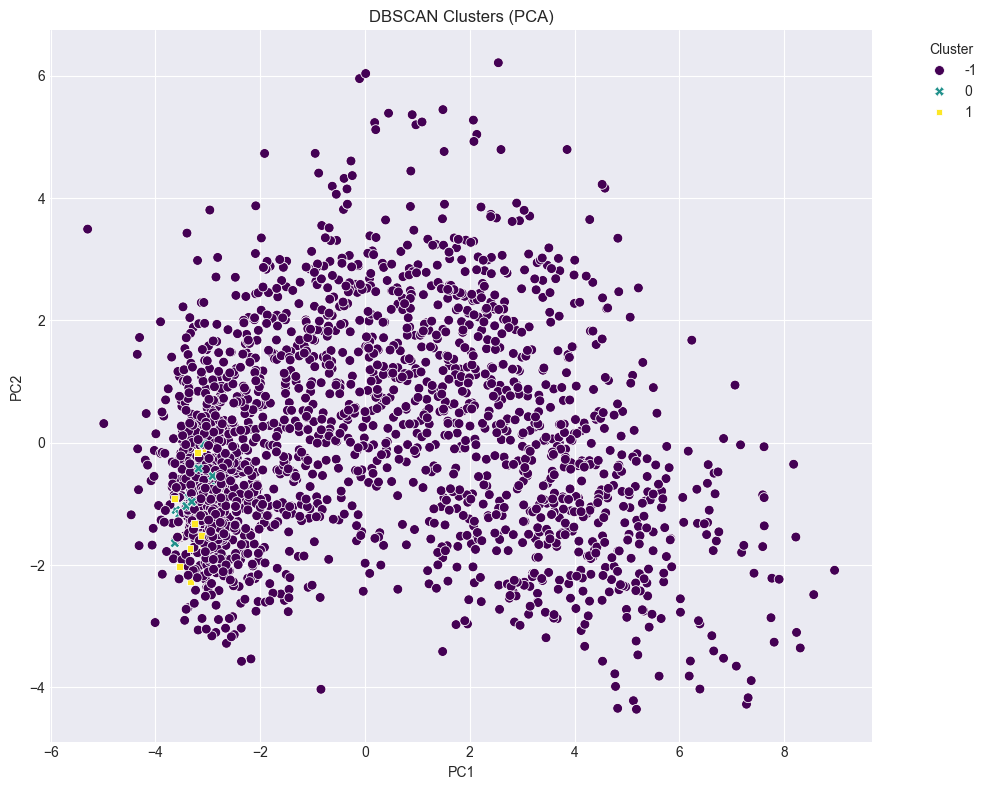

In [17]:
# Visualize DBSCAN clusters
visualize_clusters_pca(df_scaled, labels_dbscan, title='DBSCAN Clusters (PCA)')

## 8. Gaussian Mixture Model (GMM)

### 8.1 BIC Analysis for Optimal Components

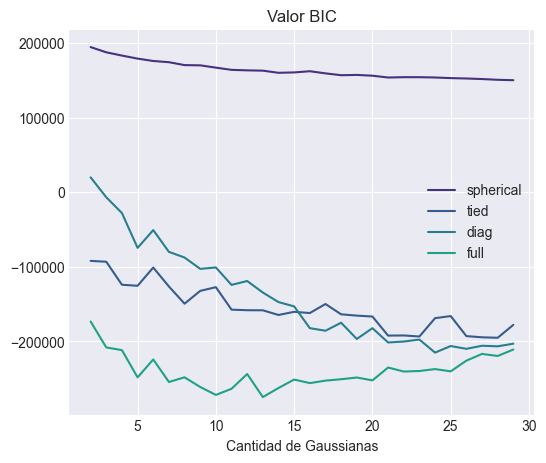

In [18]:
# Evaluate GMM using BIC across different covariance types
evaluate_gmm_bic(df_scaled, range(2, 30), covariance_types=['spherical', 'tied', 'diag', 'full'])

### 8.2 Fit Final GMM Model

In [19]:
# Based on BIC plot, choose optimal configuration
gmm_final = GaussianMixture(n_components=20, covariance_type='diag', random_state=123)
gmm_final.fit(df_scaled)
labels_gmm = gmm_final.predict(df_scaled)

print(f"GMM with 20 components (diag covariance) fitted")
print(f"BIC: {gmm_final.bic(df_scaled):.2f}")
print(f"AIC: {gmm_final.aic(df_scaled):.2f}")

GMM with 20 components (diag covariance) fitted
BIC: -194919.01
AIC: -204144.12


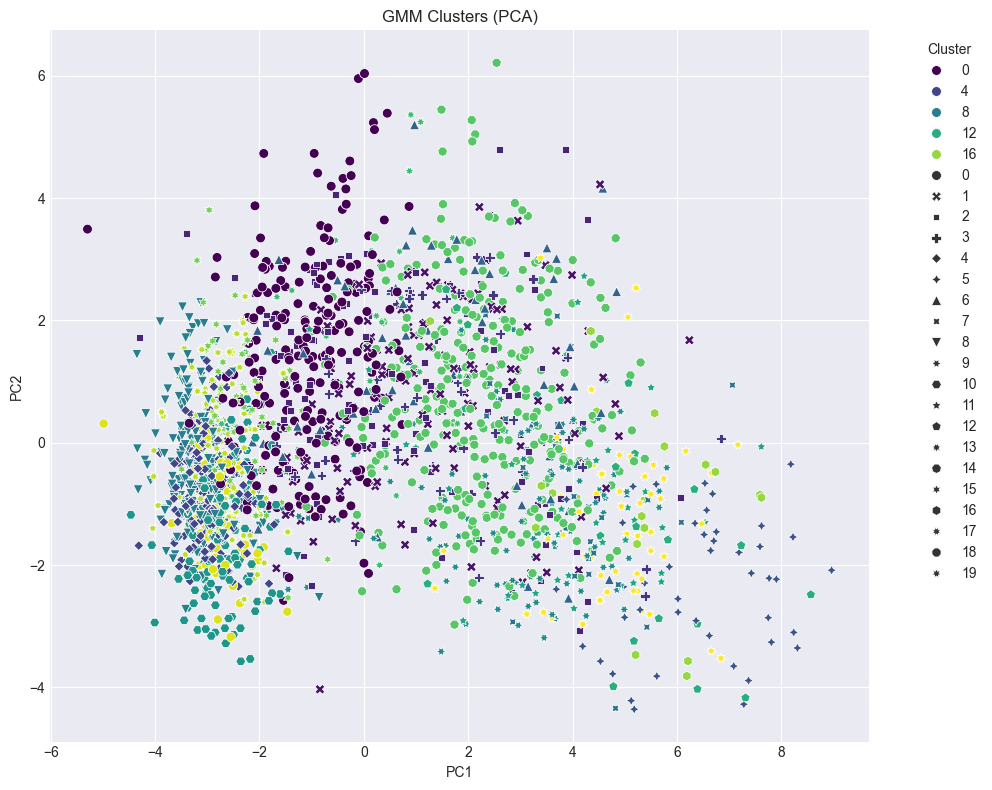

In [20]:
# Visualize GMM clusters
visualize_clusters_pca(df_scaled, labels_gmm, title='GMM Clusters (PCA)')

## 9. Model Comparison

### 9.1 Silhouette Score Comparison

In [21]:
# Compare all models using Silhouette score
labels_dict = {
    'KMeans': labels_kmeans,
    'Hierarchical': labels_h_clust,
    'DBSCAN': labels_dbscan,
    'GMM': labels_gmm
}

scores = compare_all_models_silhouette(df_scaled, labels_dict)

Silhouette para:
 KMeans: 0.1098
 Hierarchical: 0.1494
 DBSCAN: -0.1632
 GMM: 0.0520


### 9.2 Select Best Model

Based on the Silhouette scores above, select the best performing model for interpretation.

In [22]:
# Select best model (example: KMeans)
best_model_name = 'KMeans'
best_labels = labels_kmeans

print(f"Selected model: {best_model_name}")
print(f"Number of clusters: {len(np.unique(best_labels))}")

Selected model: KMeans
Number of clusters: 6


## 10. Cluster Interpretation

### 10.1 Inverse Transform Cluster Centers

Convert scaled cluster centers back to original units for interpretation.

In [23]:
# Get cluster centers (scaled) - use all_feature_cols
centers_scaled = pd.DataFrame(kmeans_final.cluster_centers_, columns=all_feature_cols)

print(f"Cluster centers shape: {centers_scaled.shape}")
print(f"Numerical columns: {len(num_feature_cols)}")
print(f"OHE columns: {len(ohe_feature_cols)}")

Cluster centers shape: (6, 40)
Numerical columns: 30
OHE columns: 10


In [24]:
# Inverse transform numerical features (scaler was fitted only on these)
centers_num_inverse = scaler.inverse_transform(centers_scaled[num_feature_cols])

# Inverse transform categorical features
centers_cat_inverse = encoder.inverse_transform(centers_scaled[ohe_feature_cols])

# Combine into final dataframe
transformed_centers = pd.DataFrame(
    np.concatenate([centers_num_inverse, centers_cat_inverse], axis=1),
    columns=num_feature_cols + categorical_cols
)

print("\nCluster Centers (Original Scale):")
transformed_centers


Cluster Centers (Original Scale):


,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Z_CostContact,Z_Revenue,Age,Tenure_Days,Total_Mnt,Total_Num_Purchases,Is_Partner,Family_Size,Days_Being_Customer,Total_Offers_Accepted,Education,Marital_Status
0,29523.460504,0.793277,0.045378,47.848739,33.087395,6.361345,25.376471,10.094118,6.485714,17.606723,1.853782,2.188235,0.537815,3.127731,6.905882,0.084034,0.005042,-0.0,0.001681,-0.0,3.0,11.0,48.789916,4604.821849,99.011765,7.707563,0.613445,2.452101,4606.821849,0.213445,Graduation,Married
1,58153.292247,0.2167,0.93837,48.395626,495.819085,24.940358,150.196819,33.232604,25.341948,66.767396,3.94831,6.793241,3.355865,8.013917,5.906561,0.083499,0.117296,0.003976,0.029821,-0.0,3.0,11.0,61.023857,4683.733598,796.298211,22.111332,0.671968,2.827038,4685.733598,0.365805,Graduation,Married
2,44201.481409,0.722114,0.996086,50.733855,79.142857,4.536204,27.763209,5.911937,4.696673,14.761252,2.452055,2.432485,0.776908,3.747554,5.726027,0.046967,0.027397,-0.0,0.005871,-0.0,3.0,11.0,62.150685,4522.55773,136.812133,9.409002,0.708415,3.426614,4524.55773,0.123288,Graduation,Married
3,72889.780788,0.036946,0.187192,50.024631,495.059113,72.571429,419.660099,104.756158,71.408867,75.726601,1.293103,5.004926,5.573892,8.519704,2.778325,0.036946,0.03202,-0.0,0.08867,-0.0,3.0,11.0,58.29803,4596.773399,1239.182266,20.391626,0.573892,1.79803,4598.773399,0.307882,Graduation,Married
4,82290.798742,0.056604,0.119497,48.031447,857.761006,58.150943,499.150943,84.295597,68.157233,77.515723,1.037736,5.540881,6.069182,8.220126,2.899371,0.157233,0.333333,0.886792,0.459119,0.0,3.0,11.0,56.509434,4603.591195,1645.031447,20.867925,0.672956,1.849057,4605.591195,2.396226,Graduation,Married
5,71054.833333,0.066667,0.433333,48.666667,898.666667,22.966667,250.3,38.733333,30.6,66.4,1.7,4.9,5.166667,8.166667,5.166667,0.233333,0.733333,0.566667,0.433333,1.0,3.0,11.0,57.866667,4613.1,1307.666667,19.933333,0.633333,2.133333,4615.1,3.633333,Graduation,Together


### 10.2 Cluster Statistics

Cluster Sizes:
Cluster
0    595
1    503
2    511
3    406
4    159
5     30
Name: count, dtype: int64


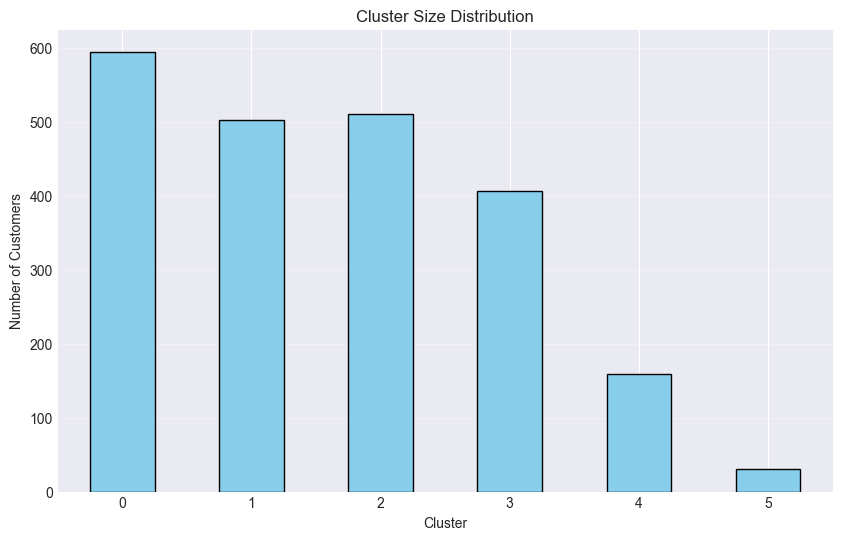

In [25]:
# Add cluster labels to scaled data
df_with_clusters = df_scaled.copy()
df_with_clusters['Cluster'] = best_labels

# Cluster size distribution
cluster_sizes = df_with_clusters['Cluster'].value_counts().sort_index()
print("Cluster Sizes:")
print(cluster_sizes)

# Visualize cluster sizes
plt.figure(figsize=(10, 6))
cluster_sizes.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Cluster Size Distribution')
plt.xlabel('Cluster')
plt.ylabel('Number of Customers')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.show()

### 10.3 Cluster Profiles

Interpret each cluster based on the transformed centers.

In [26]:
# Display key characteristics for each cluster
key_features = ['Age', 'Income', 'Total_Mnt', 'Total_Num_Purchases', 'Recency', 'Education', 'Marital_Status']
available_features = [f for f in key_features if f in transformed_centers.columns]

print("\nKey Cluster Characteristics:")
transformed_centers[available_features]


Key Cluster Characteristics:


,Age,Income,Total_Mnt,Total_Num_Purchases,Recency,Education,Marital_Status
0,48.789916,29523.460504,99.011765,7.707563,47.848739,Graduation,Married
1,61.023857,58153.292247,796.298211,22.111332,48.395626,Graduation,Married
2,62.150685,44201.481409,136.812133,9.409002,50.733855,Graduation,Married
3,58.29803,72889.780788,1239.182266,20.391626,50.024631,Graduation,Married
4,56.509434,82290.798742,1645.031447,20.867925,48.031447,Graduation,Married
5,57.866667,71054.833333,1307.666667,19.933333,48.666667,Graduation,Together


## 11. Conclusions

Summary of findings:
1. **Best Model**: [Based on Silhouette scores]
2. **Number of Clusters**: [Optimal k]
3. **Key Insights**: [Describe main customer segments]

### Next Steps:
- Deploy segmentation model
- Create targeted marketing strategies for each segment
- Monitor cluster stability over time